In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

pd.set_option('display.max_rows', None)
sns.set_context('talk')

In [2]:
mrchem_nr = pd.read_csv('datafiles/small_molecules_MRChem_NR.csv')
mrchem_zora = pd.read_csv('datafiles/small_molecules_MRChem_ZORA.csv')

orca_nr = pd.read_csv('datafiles/small_molecules_ORCA_NR.csv')
orca_zora = pd.read_csv('datafiles/small_molecules_ORCA_ZORA.csv')

mrchem = mrchem_nr.merge(mrchem_zora, how='outer', on='Molecule', suffixes=['_nr', '_zora']).sort_values(by='Molecule').set_index('Molecule')
df = orca_nr.merge(orca_zora, how='outer', on=['Molecule', 'BasisSet'], suffixes=['_nr', '_zora']).sort_values(by=['Molecule', 'BasisSet']).set_index('Molecule')

df['ref_zora'] = mrchem.Energy_zora
df['ref_nr'] = mrchem.Energy_nr

df['Error_zora'] = df.Energy_zora - df.ref_zora
df['Error_nr'] = df.Energy_nr - df.ref_nr

df.reset_index(inplace=True)

In [3]:
for mol, g in df.groupby('Molecule'):
    print('----------------------------------------------------')
    print(g[['Molecule', 'BasisSet', 'Error_zora', 'Error_nr']])

----------------------------------------------------
   Molecule         BasisSet  Error_zora  Error_nr
0    CH3BH2         cc-pcv5z    0.000145  0.000132
1    CH3BH2         cc-pcvdz    0.034398  0.033984
2    CH3BH2         cc-pcvqz    0.001132  0.001106
3    CH3BH2         cc-pcvtz    0.005532  0.005431
4    CH3BH2          cc-pv5z    0.000482  0.000370
5    CH3BH2          cc-pvdz    0.038930  0.039250
6    CH3BH2          cc-pvqz    0.002547  0.002282
7    CH3BH2          cc-pvtz    0.007520  0.007126
8    CH3BH2       def2-qzvpp    0.000971  0.000939
9    CH3BH2         def2-svp    0.084696  0.084003
10   CH3BH2        def2-tzvp    0.008722  0.008384
11   CH3BH2             pc-1    0.045517  0.045851
12   CH3BH2             pc-2    0.004880  0.005269
13   CH3BH2             pc-3    0.000211  0.000184
14   CH3BH2             pc-4    0.000048  0.000027
15   CH3BH2  zora-def2-qzvpp    0.000935  0.000927
16   CH3BH2    zora-def2-svp    0.079258  0.079788
17   CH3BH2   zora-def2-tzvp 

In [48]:
# Add familities to df
mapping = {
    'ano-rcc-dzp': 'ANO-RCC', 'ano-rcc-tzp': 'ANO-RCC', 'ano-rcc-qzp': 'ANO-RCC',
    'cc-pcvdz': 'CCc', 'cc-pcvtz': 'CCc', 'cc-pcvqz': 'CCc', 'cc-pcv5z': 'CCc',
    'def2-svp': 'Def2', 'def2-tzvp': 'Def2', 'def2-qzvpp': 'Def2',
    'pc-1': 'PC', 'pc-2': 'PC', 'pc-3': 'PC', 'pc-4': 'PC',
    'zora-def2-svp': 'Zora-Def2', 'zora-def2-tzvp': 'Zora-Def2', 'zora-def2-qzvpp': 'Zora-Def2',
    'cc-pvdz': 'CC', 'cc-pvtz': 'CC', 'cc-pvqz': 'CC', 'cc-pv5z': 'CC'}
df['Family'] = df.BasisSet.map(lambda b: mapping[b])

In [49]:
# Add zeta qualities to df
mapping = {
    'ano-rcc-dzp': 2, 'ano-rcc-tzp': 3, 'ano-rcc-qzp': 4,
    'cc-pcvdz': 2, 'cc-pcvtz': 3, 'cc-pcvqz': 4, 'cc-pcv5z': 5,
    'def2-svp': 2, 'def2-tzvp': 3, 'def2-qzvpp': 4,
    'pc-1': 2, 'pc-2': 3, 'pc-3': 4, 'pc-4': 5,
    'zora-def2-svp': 2, 'zora-def2-tzvp': 3, 'zora-def2-qzvpp': 4,
    'cc-pvdz': 2, 'cc-pvtz': 3, 'cc-pvqz': 4, 'cc-pv5z': 5}
df['Zeta'] = df.BasisSet.map(lambda b: mapping[b])

In [50]:
# Convert to long-form in errors
melted = pd.melt(df.rename(columns={'Error_zora': 'ZORA', 
                                    'Error_nr': 'NR'}), 
                 value_vars=['ZORA', 'NR'], 
                 id_vars=['BasisSet', 'Molecule', 'Family', 'Zeta'], 
                 var_name='Kind', value_name='Error')

In [53]:
# Abbreviate basis set names
melted['BasisSet'] = melted.BasisSet.str.replace('zora-def2-', '')
melted['BasisSet'] = melted.BasisSet.str.replace('def2-', '')
melted['BasisSet'] = melted.BasisSet.str.replace('cc-', '')

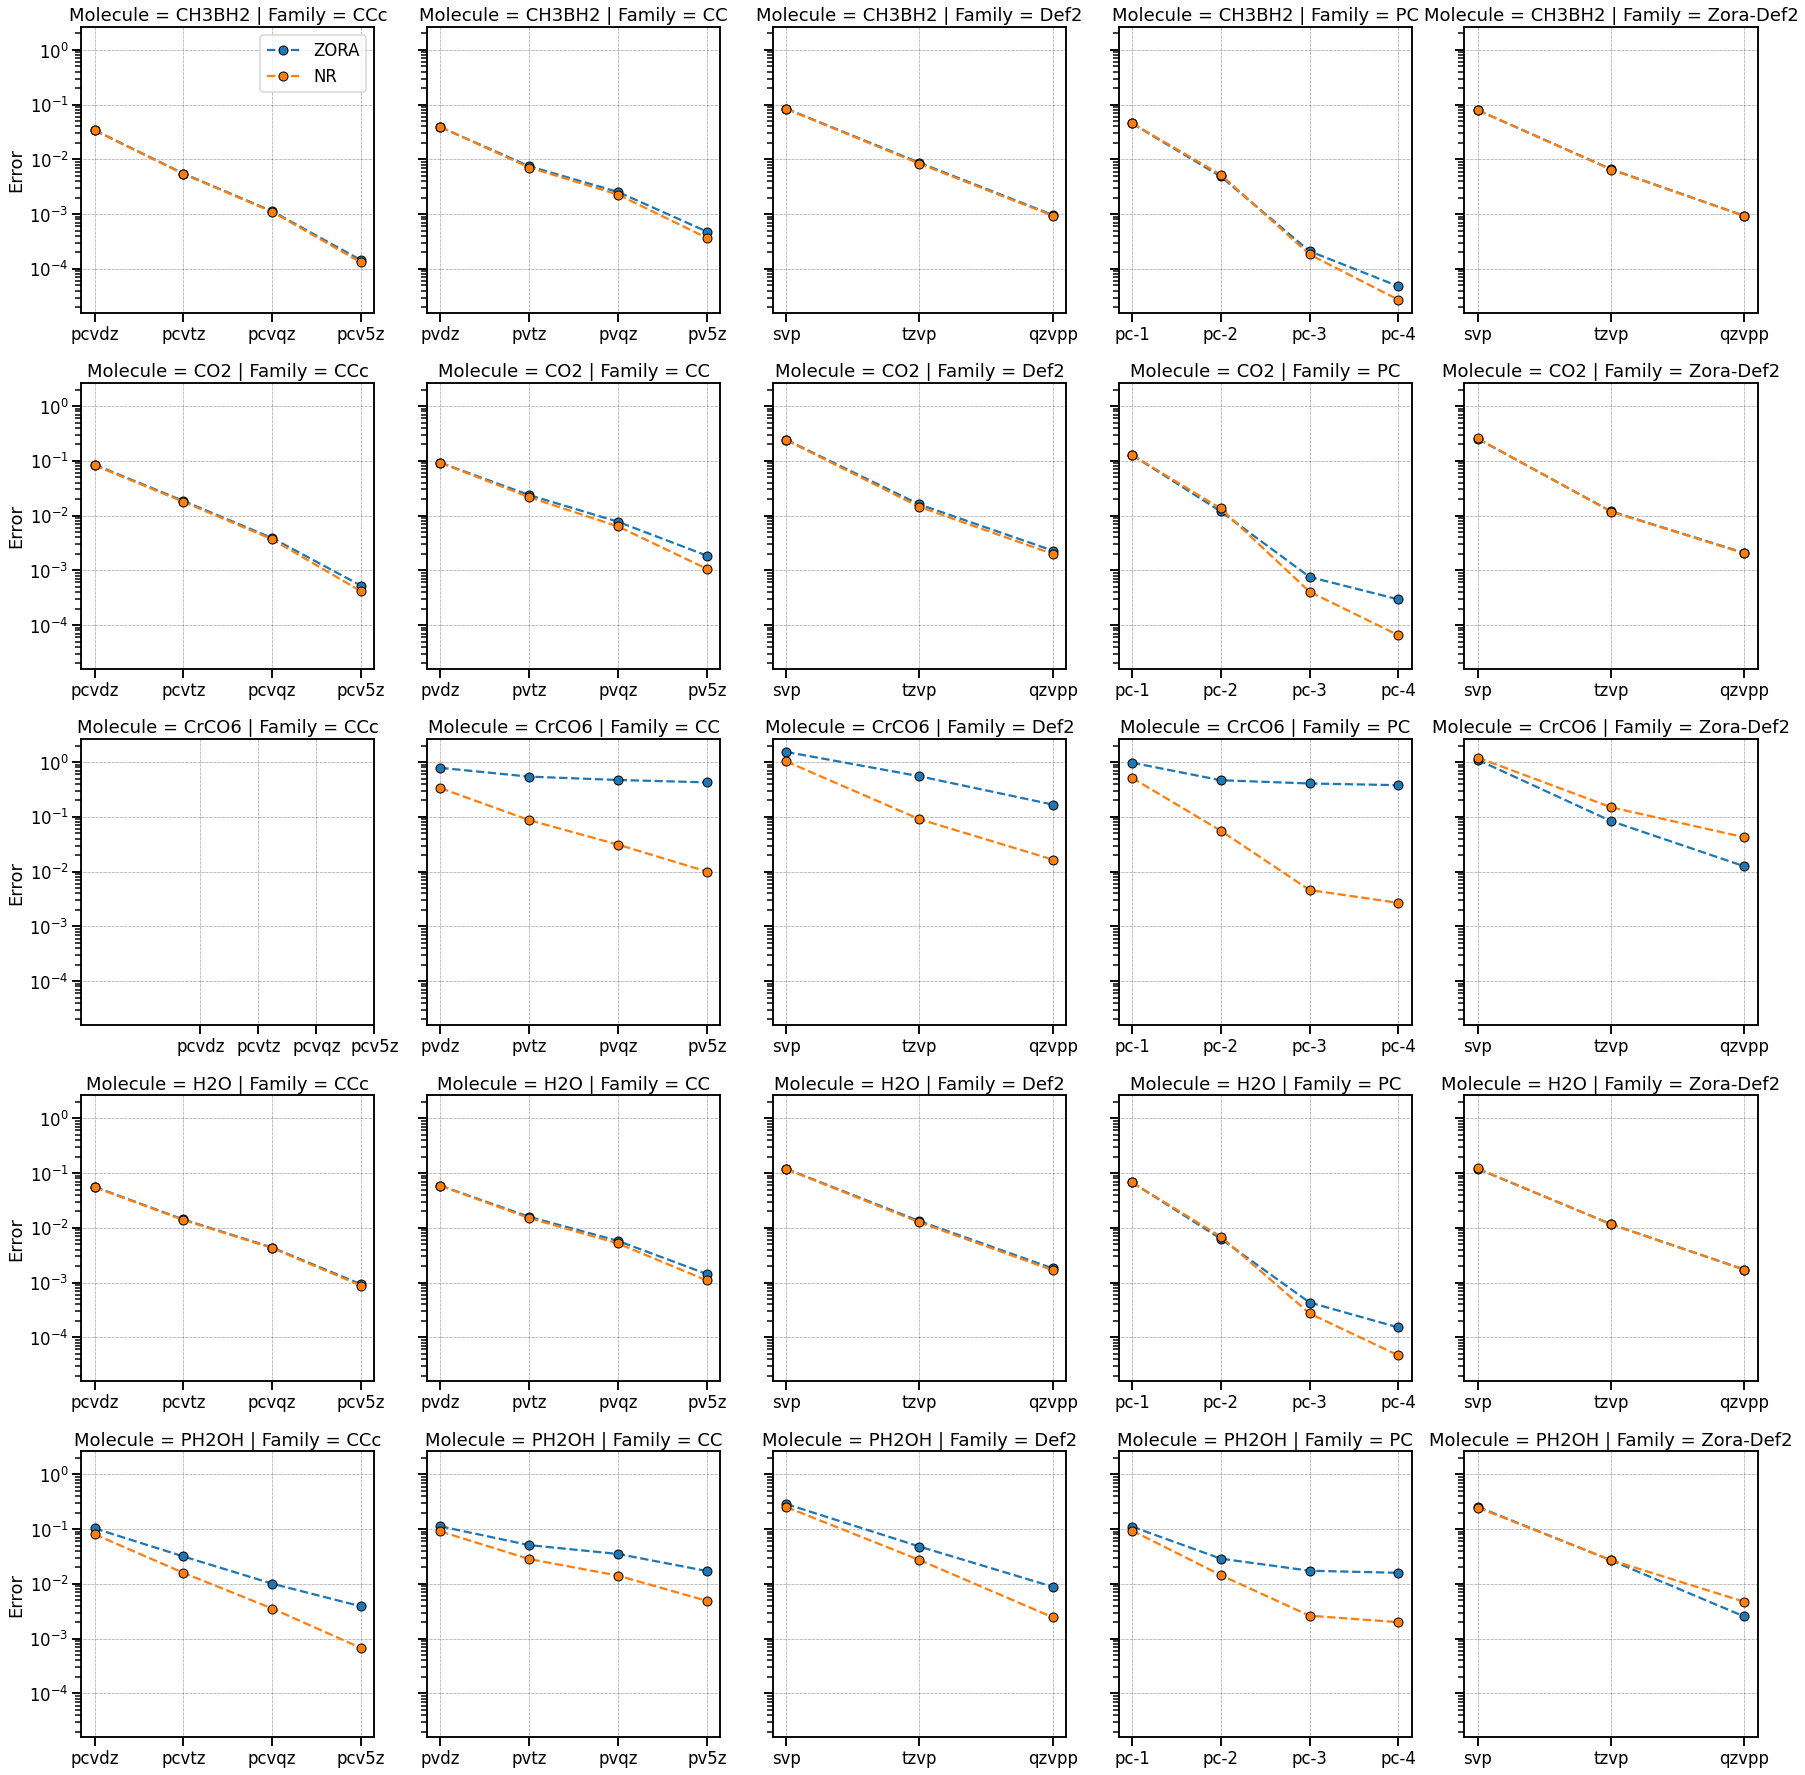

In [58]:
grid = sns.relplot(data=melted, x='Zeta', y='Error', hue='Kind', col='Family', row='Molecule', kind='line', facet_kws={'sharex': False, 'despine':False}, marker='o', mec='black', mew=1, linestyle='--', legend=False)

counter = 0
for (mol, fam), ax in grid.axes_dict.items():
    if counter == 0:
        lines = ax.get_lines()
        ax.legend(lines, ['ZORA', 'NR'])
    counter += 1
    
    ax.set_yscale('log')
    ax.grid(ls=':', lw=0.5, color='black')
    ax.set_xlabel(None)
    
    basis_sets = melted.loc[(melted.Family == fam) & (melted.Molecule == mol) & (melted.Kind == 'ZORA')].sort_values(by='Zeta').BasisSet.tolist()
    ax.set_xticks([i+2 for i in range(len(basis_sets))])
    ax.set_xticklabels(basis_sets)
    
plt.tight_layout()
plt.savefig('Figure3.png', facecolor='white')